In [1]:
import cv2
import numpy as np
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

In [16]:
def openimage(i):
    t1 = i // 10
    t2 = i % 10
    filename = "Drive Dataset/Images/image_0"+str(t1)+str(t2)+".jpg"

    return filename

In [15]:
def saveimage(i):
    t1 = i // 10
    t2 = i % 10
    filename = "Preprocessed/Images/image_0"+str(t1)+str(t2)+".jpg"

    return filename

In [14]:
def openimagep(i):
    t1 = i // 10
    t2 = i % 10
    filename = "Preprocessed/Images/image_0"+str(t1)+str(t2)+".jpg"

    return filename

In [13]:
def saveimagep(i):
    t1 = i // 10
    t2 = i % 10
    filename = "Output/Images/image_0"+str(t1)+str(t2)+".jpg"

    return filename

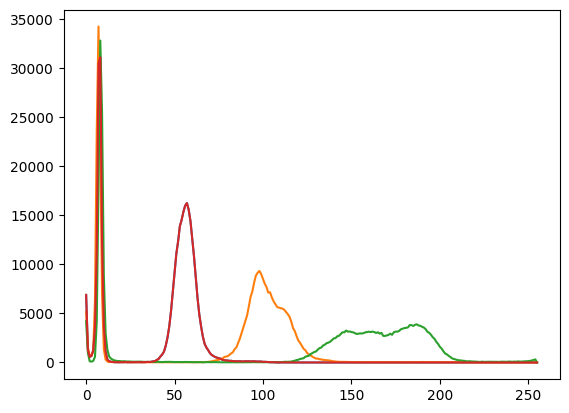

In [2]:
# Original image Histogram

img = cv2.imread('Drive Dataset/Images/image_001.jpg')
if img is None:
    print("image not found")

# img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
b,g,r = cv2.split(img)

hist = cv2.calcHist([b],[0],None,[256],[0,255])
plt.plot(hist)
hist = cv2.calcHist([g],[0],None,[256],[0,255])
plt.plot(hist)
hist = cv2.calcHist([r],[0],None,[256],[0,255])
plt.plot(hist)

hist = cv2.calcHist([img],[0],None,[256],[0,256])

cv2.imshow('original',img)
cv2.waitKey(0)
plt.plot(hist)
plt.show()

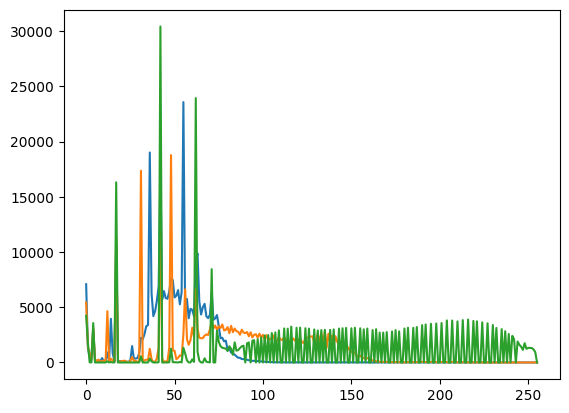

In [3]:
# Global AHE

img = cv2.imread('Drive Dataset/Images/image_001.jpg')
if img is None:
    print("image not found")

img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(img_hsv)
v = cv2.equalizeHist(v)
merged_hsv = cv2.merge((h,s,v))
bgr_enhanced = cv2.cvtColor(merged_hsv,cv2.COLOR_HSV2BGR)
b,g,r = cv2.split(bgr_enhanced)

hist = cv2.calcHist([b],[0],None,[256],[0,255])
plt.plot(hist)
hist = cv2.calcHist([g],[0],None,[256],[0,255])
plt.plot(hist)
hist = cv2.calcHist([r],[0],None,[256],[0,255])
plt.plot(hist)

cv2.imshow('globalAHE',bgr_enhanced)
cv2.waitKey(0)

plt.show()

In [30]:
# CLAHE and Median Blur

def preprocessing():
    for i in tqdm(range(1,41),desc='Pre-Processing in progress'):
        open_path = openimage(i)
        img = cv2.imread(open_path)

        if img is None:
            print(f"image {i} not found")

        dimension = img.shape

        b,g,r = cv2.split(img)
        img = g

        blank = np.zeros(img.shape,dtype='uint8')

        clahe = cv2.createCLAHE(clipLimit=2)
        clahe_image = clahe.apply(img)

        blur = cv2.medianBlur(clahe_image,55)
        
        save_path = saveimage(i)
        cv2.imwrite(save_path,blur)

In [47]:
def solution_set(npop,shape):
    height,width = shape[0],shape[1]
    xmin,ymin = 50,200
    xmax,ymax = width-51,height-201
    random_points = []
    b1 = random.sample(range(ymin,ymax), npop)
    b2 = random.sample(range(xmin,xmax), npop)
    
    return list(zip(b1,b2))

In [51]:
def fitness_value(img,point):
    width,height = point[1],point[0]
    radius = 35

    img = img[height-20:height+21,width-20:width+21]
    s = img.sum()
    y = 1 - (s / 1000)
    
    return y

In [46]:
def opticdecross( population, mutant, cross, shape ):
    height, width = shape[0], shape[1]
    xmin, ymin = 50,200
    xmax, ymax = width-50, height-200
    ir = random.randrange(0,2)
    cross_point = [0,0]
    for i in range(2):
        if( random.uniform(0,1) <= cross or i==ir ):
            if i == 0:
                if( mutant[0] <= ymax and mutant[0] >= ymin ):
                    cross_point[0] = mutant[0]
                else:
                    cross_point[0] = population[0]
            if i == 1:
                if( mutant[1] <= xmax and mutant[1] >= xmin ):
                    cross_point[1] = mutant[1]
                else:
                    cross_point[1] = population[1]
    return tuple(cross_point)

In [48]:
def check_bounds(mutant,shape):
    if mutant[0] >= 200 and mutant[0] <= shape[0]-200 and mutant[1] >= 50 and mutant[1] <= shape[1]-50:
        return mutant
    elif mutant[0] >= 200 and mutant[0] <= shape[0]-200:
        if mutant[1] < 50:
            return (mutant[0],50)
        elif mutant[1] > shape[1]-50:
            return (mutant[0],shape[1]-50)
    elif mutant[1] >= 50 and mutant[1] <= shape[1]-50:
        if mutant[0] < 200:
            return (200,mutant[1])
        elif mutant[0] > shape[0]-200:
            return (shape[0]-200,mutant[1])
    elif mutant[0] < 200 and mutant[1] < 50:
        return (200,50)
    elif mutant[0] < 200 and mutant[1] > shape[1]-50:
        return (200,shape[1]-50)
    elif mutant[0] > shape[0]-200 and mutant[1] < 50:
        return (shape[0]-200,50)
    elif mutant[0] > shape[0]-200 and mutant[1] > shape[1]-50:
        return (shape[0]-200,shape[1]-50)

In [49]:
def segmentation():
    for i in tqdm(range(1,41),desc='Image Segmentation in progress'):
        open_path = openimagep(i)
        img = cv2.imread(open_path)
        img,g,r = cv2.split(img)

        npop,ngen = 40,100

        if img is None:
            print(f"image {i} is not found")
        
        populations = [solution_set(npop,img.shape)]

        fitness = {}

        for j in range(npop):
            if populations[0][j] not in fitness:
                fitness[populations[0][j]] = fitness_value(img,populations[0][j])
        
        a,f,cross = [_ for _ in range(npop)],0.4,0.7

        min_point,min_fitness = None,None

        for j in range(ngen):
            if j == 0:k = 0
            else:k = j-1

            for m in range(npop):
                b = random.sample(range(npop),npop)
                c = [_ for _ in b if _ != m] 
                r1 = a[b[c[0]]]
                r2 = a[b[c[1]]]
                r3 = a[b[c[2]]]

                mutant = [int(abs(populations[k][r1][0] + f*(-(populations[k][r2][0])-populations[k][r3][0]))),int(abs(populations[k][r1][1] + f*(-(populations[k][r2][1])-populations[k][r3][1])))]

                mutant = check_bounds(mutant,img.shape)

                cross_point = opticdecross(populations[k][m],mutant,cross,img.shape)

                if cross_point not in fitness:
                    q1 = fitness_value(img,cross_point)
                    fitness[cross_point] = q1
                q2 = fitness[populations[k][m]]

                if j == len(populations):
                    populations.append([])

                if q1 <= q2:
                    populations[j].append(cross_point)
                    if min_fitness is None or min_fitness >= q1:
                        min_fitness,min_point = q1,cross_point

                else:
                    populations[j].append(populations[k][m])
                    if min_fitness is None or min_fitness >= q2:
                        min_fitness,min_point = q2,populations[k][m]

        cv2.circle(img,(min_point[1],min_point[0]),50,(0,255,255),2)
        save_path = saveimagep(i)
        cv2.imwrite(save_path,img)


In [52]:
preprocessing()
segmentation()

Image Segmentation in progress: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]
